# Entraînement baseline du modèle CNN
Ce notebook présente :
- Chargement des données prétraitées
- Définition d’un modèle CNN simple
- Entraînement et évaluation de la baseline
- Sauvegarde du meilleur modèle

## Imports & Paramètres

In [1]:
import os, yaml, random
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import shutil
from tensorflow.keras.models import load_model
import numpy as np
from PIL import Image
import glob
from src.config_utils import load_config
from src.data_loader import load_from_splits
import subprocess
from datetime import date

In [2]:
# Charger la configuration
cfg = load_config('../configs/config_baseline.yaml')

# Fixer les seeds pour la reproductibilité
random.seed(cfg['seed'])
np.random.seed(cfg['seed'])
tf.random.set_seed(cfg['seed'])

# Paramètres depuis la config
# Répertoires
DATA_RAW_DIR       = cfg['data']['raw_dir']
DATA_PROCESSED_DIR = cfg['data']['processed_dir']
CHECKPOINT_DIR = os.path.join('..', 'outputs', 'checkpoints', 'all')
# Hyperparamètres
IMG_SIZE           = tuple(cfg['preprocessing']['target_size'])
BATCH_SIZE         = cfg['training']['batch_size']
EPOCHS             = cfg['training']['epochs']
LEARNING_RATE      = cfg['training']['learning_rate']
EARLYSTOP_CFG      = cfg['training']['early_stopping']

# Chemins vers les fichiers de splits
TRAIN_SPLIT = os.path.join('..', 'splits', 'all', 'baseline', 'train.txt')
VAL_SPLIT   = os.path.join('..', 'splits', 'all', 'baseline', 'val.txt')

In [3]:
# Génération d'un run_id unique
today = date.today().isoformat()
commit_hash = subprocess.check_output(
    ['git','rev-parse','--short','HEAD']
).decode().strip()
run_id = f"{today}_{commit_hash}"

# Préparation des dossiers de sortie
CKPT_DIR = os.path.join('..','outputs','checkpoints','all')
CFG_OUT  = os.path.join('..','outputs','configs','all')
FIG_OUT  = os.path.join('..','outputs','figures', 'all')
LOG_OUT  = os.path.join('..','outputs','logs', 'all')

for d in (CKPT_DIR, CFG_OUT, FIG_OUT, LOG_OUT):
    os.makedirs(d, exist_ok=True)

print("Run ID :", run_id)

Run ID : 2025-07-05_892d3f0


## Chargement des données

In [4]:
# Construction des tf.data.Datasets
train_ds, class_indices = load_from_splits(
    TRAIN_SPLIT,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE
)

val_ds, _ = load_from_splits(
    VAL_SPLIT,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE
)

# Nombre de classes
num_classes = len(class_indices)
print("Classes et indices :", class_indices)
print("Taille train:", train_ds.cardinality().numpy(),
      "— val:", val_ds.cardinality().numpy())

Classes et indices : {'non_toxic': 0, 'toxic': 1}
Taille train: 13 — val: 3


## Définition du modèle

In [5]:
def build_baseline_cnn(input_shape, num_classes):
    model = models.Sequential([
        tf.keras.Input(shape=input_shape),
        layers.Conv2D(32, 3, activation="relu", padding="same"),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation="relu", padding="same"),
        layers.MaxPooling2D(),
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax")
    ])
    return model

model = build_baseline_cnn(IMG_SIZE + (3,), num_classes)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,970 (109.26 KB)

 Trainable params: 27,970 (109.26 KB)

 Non-trainable params: 0 (0.00 B)

## Callbacks et entraînement

In [6]:
# Checkpoint
checkpoint_path = os.path.join(
     CKPT_DIR,
     f"{run_id}_model.keras"
 )

checkpoint_cb = callbacks.ModelCheckpoint(
     checkpoint_path,
     save_best_only=True, monitor="val_accuracy", mode="max"
)

# Early stopping
earlystop_cb = callbacks.EarlyStopping(
    monitor=EARLYSTOP_CFG['monitor'],
    patience=EARLYSTOP_CFG['patience'],
    restore_best_weights=True
)

# Entraînement
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[checkpoint_cb,
               callbacks.EarlyStopping(**EARLYSTOP_CFG, restore_best_weights=True)]
)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.5497 - loss: 0.6898 - val_accuracy: 0.6364 - val_loss: 0.6776
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.6052 - loss: 0.6829 - val_accuracy: 0.6364 - val_loss: 0.6770
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.5730 - loss: 0.6847 - val_accuracy: 0.6364 - val_loss: 0.6745
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.5328 - loss: 0.6929 - val_accuracy: 0.6364 - val_loss: 0.6706
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.5665 - loss: 0.6826 - val_accuracy: 0.6364 - val_loss: 0.6638
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.5677 - loss: 0.6757 - val_accuracy: 0.6364 - val_loss: 0.6506
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.5531 - loss: 0.6882 - val_accuracy: 0.6364 - val_loss: 0.6590
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.5943 - loss: 0.6693 - val_accuracy: 0.

## Visualisation des courbes

Courbes sauvegardées dans : ../outputs/figures/all/2025-07-05_892d3f0_training_curves.png


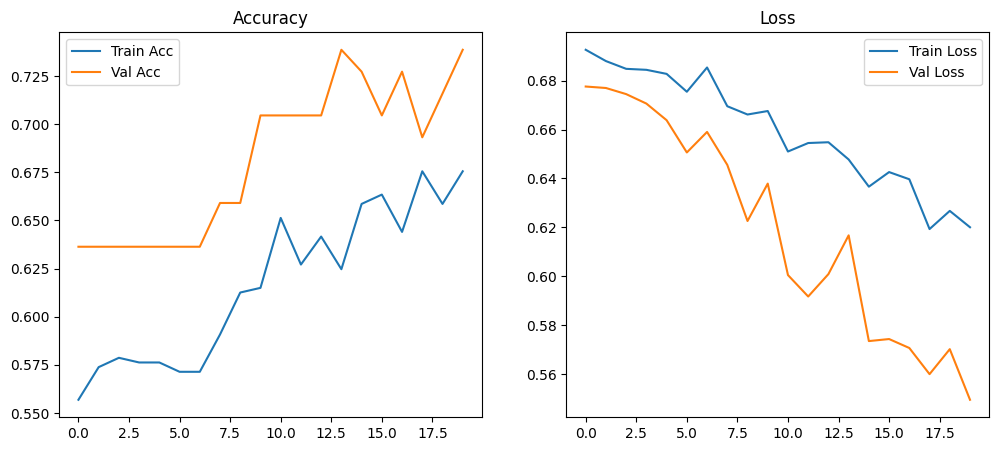

Metrics sauvegardées dans : ../outputs/logs/all/2025-07-05_892d3f0_metrics.txt


In [7]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.legend(); plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend(); plt.title("Loss")

# Sauvegarde de la figure des courbes
fig_path = os.path.join(FIG_OUT, f"{run_id}_training_curves.png")
plt.savefig(fig_path, dpi=300)
print("Courbes sauvegardées dans :", fig_path)

plt.show()

# Sauvegarde des métriques dans un fichier texte
metrics_path = os.path.join(LOG_OUT, f"{run_id}_metrics.txt")
with open(metrics_path, 'w') as f:
    for key, vals in history.history.items():
        f.write(f"{key}: {vals}\n")
print("Metrics sauvegardées dans :", metrics_path)

## Sauvegarde finale et exemple de prédiction

In [8]:
# Sauvegarde de la config du run
src_cfg = '../configs/config_baseline.yaml'
dst_cfg = os.path.join(CFG_OUT, f"{run_id}_config_baseline.yaml")
shutil.copy(src_cfg, dst_cfg)
print("Config sauvegardée dans :", dst_cfg)

Config sauvegardée dans : ../outputs/configs/all/2025-07-05_892d3f0_config_baseline.yaml


In [9]:
# 1. Récupérer le dernier checkpoint
ckpt_files = glob.glob(os.path.join(CKPT_DIR, '*.keras'))
latest_ckpt = max(ckpt_files, key=os.path.getctime)
print("Chargement du modèle depuis :", latest_ckpt)

# 2. Charger le modèle
best_model = load_model(latest_ckpt)

# 3. Préparer une image d’exemple
img_path = os.path.join('..', 'data', 'processed', 'all', 'toxic', 'Image_4646.tif')
img = Image.open(img_path).resize(IMG_SIZE)
x = np.array(img) / 255.0

# 4. Prédiction
pred = best_model.predict(x[np.newaxis])[0]
pred_idx = np.argmax(pred)

# 5. Conversion indice → nom de classe
inv_class_map = {v: k for k, v in class_indices.items()}
pred_label = inv_class_map[pred_idx]

print(f"Classe prédite : {pred_label} (indice {pred_idx})")

Chargement du modèle depuis : ../outputs/checkpoints/all/2025-07-05_892d3f0_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Classe prédite : non_toxic (indice 0)
